# Sequence to Sequence Models for Timeseries Regression


In this notebook we are going to tackle a harder problem: 
- predicting the future on a timeseries
- by outputing sequence of predictions
- with rough uncertainty (uncalibrated)
- using forecasted information (like weather report, week, or cycle of the moon)

Not many papers benchmark movels for multivariate regression, much less seq prediction with uncertainty. So this notebook will try a range of models on a range of dataset.

We do this using a sequence to sqequence interface

<img src="../reports/figures/Seq2Seq for regression.png" />


In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change. But blacklist large modules
%load_ext autoreload
%autoreload 2
%aimport -pandas
%aimport -torch
%aimport -numpy
%aimport -matplotlib
%aimport -dask
%aimport -tqdm
%matplotlib inline

In [225]:
# Imports
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
import torch
import torch.utils.data

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 2.0)
plt.style.use('ggplot')

from pathlib import Path
from tqdm.auto import tqdm

import pytorch_lightning as pl

/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
import warnings
warnings.simplefilter('once')

In [4]:
from seq2seq_time.data.dataset import Seq2SeqDataSet, Seq2SeqDataSets
from seq2seq_time.predict import predict, predict_multi
from seq2seq_time.util import dset_to_nc

/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
import logging, sys
# logging.basicConfig(stream=sys.stdout, level=logging.INFO)

/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/holoviews/operation/datashader.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Callable


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
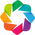

In [6]:
import holoviews as hv
from holoviews import opts
from holoviews.operation.datashader import datashade, dynspread
hv.extension('bokeh')

## Parameters

In [36]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'using {device}')

columns_target=['energy(kWh/hh)']
window_past = 48*2
window_future = 48*2
batch_size = 128
num_workers = 5
freq = '30T'
max_rows = 5e5
datasets_root = Path('../data/processed/')
window_past

using cuda


96

## Plot helpers

/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AttributeError: 'dict' object has no attribute 'targets'

In [248]:
def plot_prediction(ds_preds, i, ax=None, title='', std=False, label='pred', legend=False):
    """Plot a prediction into the future, at a single point in time."""    
    d = ds_preds.isel(t_source=i)

    # Get arrays
    xf = d.t_target
    yp = d.y_pred
    s = d.y_pred_std
    yt = d.y_true
    now = d.t_source.squeeze()
    
    plt.scatter(xf, yt, c='k', s=6, label='true' if legend else None)
    ylim = plt.ylim()

    # plot prediction
    if std:
        plt.fill_between(xf, yp-2*s, yp+2*s, alpha=0.25,
                facecolor="b",
                interpolate=True,
                label="2 std" if legend else None,)
    plt.plot(xf, yp, label=label)

    # plot true
    plt.scatter(
        d.t_past,
        d.y_past,
        c='k',
        s=6
    )
    
    # plot a red line for now
    plt.vlines(x=now, ymin=ylim[0], ymax=ylim[1], color='grey', ls='--')
    plt.ylim(*ylim)

    now=pd.Timestamp(now.values)
    plt.title(title or f'Prediction NLL={d.nll.mean().item():2.2g}')
    plt.xticks(rotation=0)    
    if legend:
        plt.legend()
    plt.xlabel(f'{now}')
    plt.ylabel(ds_preds.attrs.targets)
    return now

def plot_performance(ds_preds, full=False):
    """Multiple plots using xr_preds"""
    plot_prediction(ds_preds, 24, std=True, legend=True)

    ds_preds.mean('t_source').plot.scatter('t_ahead_hours', 'nll') # Mean over all predictions
    n = len(ds_preds.t_source)
    plt.ylabel('Negative Log Likelihood (lower is better)')
    plt.xlabel('Hours ahead')
    plt.title(f'NLL vs time ahead (no. samples={n})')
    plt.show()

    # Make a plot of the NLL over time. Does this solution get worse with time?
    if full:
        d = ds_preds.mean('t_ahead').groupby('t_source').mean().plot.scatter('t_source', 'nll')
        plt.xticks(rotation=45)
        plt.title('NLL over source time (lower is better)')
        plt.show()

    # A scatter plot is easy with xarray
    if full:
        plt.figure(figsize=(5, 5))
        ds_preds.plot.scatter('y_true', 'y_pred', s=.01)
        plt.show()

/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
def plot_hist(trainer):
    try:
        df_hist = pd.read_csv(trainer.logger.experiment.metrics_file_path)
        df_hist['epoch'] = df_hist['epoch'].ffill()
        df_histe = df_hist.set_index('epoch').groupby('epoch').mean()
        if len(df_histe)>1:
            df_histe[['loss/train', 'loss/val']].plot(title='history')
        return df_histe
    except Exception:
        pass

## Lightning

In [10]:
import pytorch_lightning as pl

class PL_MODEL(pl.LightningModule):
    def __init__(self, model, lr=3e-4, patience=None, weight_decay=0):
        super().__init__()
        self._model = model
        self.lr = lr
        self.patience = patience
        self.weight_decay = weight_decay

    def forward(self, x_past, y_past, x_future, y_future=None):
        """Eval/Predict"""
        y_dist, extra = self._model(x_past, y_past, x_future, y_future)
        assert torch.isfinite(y_dist.loc).all(), 'output should be finite'
        return y_dist, extra

    def training_step(self, batch, batch_idx, phase='train'):
        x_past, y_past, x_future, y_future = batch
        y_dist, extra = self.forward(*batch)
        loss = -y_dist.log_prob(y_future).mean()
        assert torch.isfinite(loss).all(), 'loss should be finite'
        self.log_dict({f'loss/{phase}':loss})
        if ('loss' in extra) and (phase=='train'):
            # some models have a special loss
            loss = extra['loss']
            self.log_dict({f'model_loss/{phase}':loss})
        return loss

    def validation_step(self, batch, batch_idx):
        return self.training_step(batch, batch_idx, phase='val')
    
    def configure_optimizers(self):
        optim = torch.optim.AdamW(self.parameters(), lr=self.lr,  weight_decay=self.weight_decay)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optim,
            patience=self.patience,
            verbose=True,
            min_lr=1e-7,
        ) if self.patience else None
        return {'optimizer': optim, 'lr_scheduler': scheduler, 'monitor': 'loss/val'}

In [11]:
# # Run
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [12]:
# Models
from seq2seq_time.models.lstm_seq2seq import LSTMSeq2Seq
from seq2seq_time.models.lstm_seq import LSTMSeq
from seq2seq_time.models.lstm import LSTM
from seq2seq_time.models.baseline import BaselineLast
from seq2seq_time.models.transformer import Transformer
from seq2seq_time.models.transformer_autor import TransformerAutoR
from seq2seq_time.models.transformer_seq2seq import TransformerSeq2Seq
from seq2seq_time.models.transformer_seq import TransformerSeq
from seq2seq_time.models.neural_process import RANP
from seq2seq_time.models.transformer_process import TransformerProcess
from seq2seq_time.models.tcn import TemporalConvNet
# ## Plots

In [13]:
import gc

def free_mem():
    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()

In [14]:
models = [
    lambda: BaselineLast(),
#     lambda: TransformerAutoR(input_size,
#         output_size, hidden_out_size=32),
    lambda: RANP(input_size,
        output_size, hidden_dim=32, 
         latent_dim=64, n_decoder_layers=4),
    lambda: LSTM(input_size,
         output_size,
         hidden_size=80,
         lstm_layers=3,
         lstm_dropout=0.3),
    lambda: LSTMSeq2Seq(input_size,
                output_size,
                hidden_size=64,
                lstm_layers=2,
                lstm_dropout=0.25),
    lambda: TransformerSeq2Seq(input_size,
                       output_size,
                       hidden_size=128,
                       nhead=8,
                       nlayers=4,
                       attention_dropout=0.2),
    lambda: Transformer(input_size,
                output_size,
                attention_dropout=0.2,
                nhead=8,
                nlayers=8,
                hidden_size=128),
    lambda :TransformerProcess(input_size,
                output_size, hidden_size=16,
        latent_dim=8, dropout=0.5,
        nlayers=4,)
#     lambda :TemporalConvNet()
]
# models

In [15]:
from seq2seq_time.data.data import IMOSCurrentsVel, AppliancesEnergyPrediction, BejingPM25, GasSensor, MetroInterstateTraffic

datasets = [BejingPM25, GasSensor, AppliancesEnergyPrediction, MetroInterstateTraffic, IMOSCurrentsVel]
datasets

[seq2seq_time.data.data.IMOSCurrentsVel,
 seq2seq_time.data.data.BejingPM25,
 seq2seq_time.data.data.GasSensor,
 seq2seq_time.data.data.AppliancesEnergyPrediction,
 seq2seq_time.data.data.MetroInterstateTraffic]

In [16]:
# GasSensor(datasets_root)

/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Train

In [17]:
from collections import defaultdict
results = defaultdict(dict)

In [18]:
from seq2seq_time.metrics import rmse, smape

In [19]:
for Dataset in datasets:
    dataset_name = Dataset.__name__
    dataset = Dataset(datasets_root)
    ds_train, ds_test = dataset.to_datasets(window_past=window_past,
                                            window_future=window_future)

    # Init data
    x_past, y_past, x_future, y_future = ds_train.get_rows(10)
    input_size = x_past.shape[-1]
    output_size = y_future.shape[-1]

Using downloaded and verified file: ../data/processed/gas-sensor-array-temperature-modulation.zip


In [20]:
for Dataset in datasets:
    dataset_name = Dataset.__name__
    dataset = Dataset(datasets_root)
    ds_train, ds_test = dataset.to_datasets(window_past=window_past,
                                            window_future=window_future)

    # Init data
    x_past, y_past, x_future, y_future = ds_train.get_rows(10)
    input_size = x_past.shape[-1]
    output_size = y_future.shape[-1]

    # Loaders
    dl_train = DataLoader(ds_train,
                          batch_size=batch_size,
                          shuffle=True,
                          pin_memory=num_workers == 0,
                          num_workers=num_workers)
    dl_test = DataLoader(ds_test,
                         batch_size=batch_size,
                         num_workers=num_workers)

    for m_fn in models:
        try:
            free_mem()
            pt_model = m_fn()
            model_name = type(pt_model).__name__
            print(dataset_name, model_name)

            # Wrap in lightning
            patience = 2
            model = PL_MODEL(pt_model,
                             lr=3e-4, patience=patience,
                             weight_decay=1e-5).to(device)

            # Trainer            
            trainer = pl.Trainer(
                gpus=1,
                min_epochs=2,
                max_epochs=20,
                amp_level='O1',
                precision=16,
                
                limit_train_batches=1000,
                limit_val_batches=100,
                logger=CSVLogger("../outputs", name=f'{dataset_name}_{model_name}'),
                callbacks=[
                    EarlyStopping(monitor='loss/val', patience=patience * 2, verbose=True),
                ],
            )

            # Train
            trainer.fit(model, dl_train, dl_test)

            ds_preds = predict(model.to(device),
                               ds_test,
                               batch_size * 2,
                               device=device,
                               scaler=dataset.output_scaler)

            print(dataset_name, model_name)
            print(f'mean_NLL {ds_preds.nll.mean().item():2.2f}')
            loss = ds_preds.nll.mean().item()

            # Performance
#             print(plot_hist(trainer))
#             plot_performance(ds_preds)

            metrics = dict(
                rmse=rmse(ds_preds.y_true, ds_preds.y_pred).item(), 
                smape=smape(ds_preds.y_true, ds_preds.y_pred).item(), 
                nll=ds_preds.nll.mean().item()
                )
            results[dataset_name][model_name] = metrics
            df_results = pd.concat({k:pd.DataFrame(v) for k,v in results.items()})
            display(df_results)
            
            dset_to_nc(ds_preds, Path(trainer.logger.experiment.log_dir)/'ds_preds.nc')
            model.cpu()
        except Exception as e:
            logging.exception('failed to run model')
            
df_results = pd.concat({k:pd.DataFrame(v) for k,v in results.items()})
display(df_results)

/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


IMOSCurrentsVel BaselineLast


EarlyStopping mode auto is unknown, fallback to auto mode.
EarlyStopping mode set to min for monitoring loss/val.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name   | Type         | Params
----------------------------------------
0 | _model | BaselineLast | 1     


Epoch     4: reducing learning rate of group 0 to 3.0000e-05.


IMOSCurrentsVel BaselineLast
mean_NLL 1.63


BaselineLast
IMOSCurrentsVel nll        1.633936
                rmse       0.257789
                smape      0.285106

EarlyStopping mode auto is unknown, fallback to auto mode.
EarlyStopping mode set to min for monitoring loss/val.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name   | Type | Params
--------------------------------
0 | _model | RANP | 109 K 


IMOSCurrentsVel RANP


Epoch     4: reducing learning rate of group 0 to 3.0000e-05.


IMOSCurrentsVel RANP
mean_NLL 23.31


BaselineLast       RANP
IMOSCurrentsVel rmse       0.257789   0.538145
                smape      0.285106   0.707343
                nll        1.633936  23.305540

EarlyStopping mode auto is unknown, fallback to auto mode.
EarlyStopping mode set to min for monitoring loss/val.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name   | Type | Params
--------------------------------
0 | _model | LSTM | 139 K 


IMOSCurrentsVel LSTM


Epoch     4: reducing learning rate of group 0 to 3.0000e-05.


IMOSCurrentsVel LSTM
mean_NLL 19.44


BaselineLast       RANP       LSTM
IMOSCurrentsVel rmse       0.257789   0.538145   0.546141
                smape      0.285106   0.707343   0.719748
                nll        1.633936  23.305540  19.444048

EarlyStopping mode auto is unknown, fallback to auto mode.
EarlyStopping mode set to min for monitoring loss/val.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name   | Type        | Params
---------------------------------------
0 | _model | LSTMSeq2Seq | 114 K 


IMOSCurrentsVel LSTMSeq2Seq


Epoch     4: reducing learning rate of group 0 to 3.0000e-05.


IMOSCurrentsVel LSTMSeq2Seq
mean_NLL 14.52


BaselineLast       RANP       LSTM  LSTMSeq2Seq
IMOSCurrentsVel rmse       0.257789   0.538145   0.546141     0.548482
                smape      0.285106   0.707343   0.719748     0.716110
                nll        1.633936  23.305540  19.444048    14.519804

EarlyStopping mode auto is unknown, fallback to auto mode.
EarlyStopping mode set to min for monitoring loss/val.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name   | Type               | Params
----------------------------------------------
0 | _model | TransformerSeq2Seq | 2 M   


IMOSCurrentsVel TransformerSeq2Seq


Epoch     4: reducing learning rate of group 0 to 3.0000e-05.


IMOSCurrentsVel TransformerSeq2Seq
mean_NLL 46.98


BaselineLast       RANP       LSTM  LSTMSeq2Seq  \
IMOSCurrentsVel rmse       0.257789   0.538145   0.546141     0.548482   
                smape      0.285106   0.707343   0.719748     0.716110   
                nll        1.633936  23.305540  19.444048    14.519804   

                       TransformerSeq2Seq  
IMOSCurrentsVel rmse             0.579640  
                smape            0.769928  
                nll             46.982059

EarlyStopping mode auto is unknown, fallback to auto mode.
EarlyStopping mode set to min for monitoring loss/val.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name   | Type        | Params
---------------------------------------
0 | _model | Transformer | 2 M   


IMOSCurrentsVel Transformer


ERROR:root:failed to run model
Traceback (most recent call last):
  File "<ipython-input-20-656930eef8bd>", line 52, in <module>
    trainer.fit(model, dl_train, dl_test)
  File "/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py", line 440, in fit
    results = self.accelerator_backend.train()
  File "/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/pytorch_lightning/accelerators/gpu_accelerator.py", line 54, in train
    results = self.train_or_test()
  File "/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/pytorch_lightning/accelerators/accelerator.py", line 66, in train_or_test
    results = self.trainer.train()
  File "/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py", line 462, in train
    self.run_sanity_check(self.get_model())
  File "/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/pytorch_lightning/tr

IMOSCurrentsVel TransformerProcess


Epoch     5: reducing learning rate of group 0 to 3.0000e-05.


IMOSCurrentsVel TransformerProcess
mean_NLL 7.35


BaselineLast       RANP       LSTM  LSTMSeq2Seq  \
IMOSCurrentsVel rmse       0.257789   0.538145   0.546141     0.548482   
                smape      0.285106   0.707343   0.719748     0.716110   
                nll        1.633936  23.305540  19.444048    14.519804   

                       TransformerSeq2Seq  TransformerProcess  
IMOSCurrentsVel rmse             0.579640            0.541376  
                smape            0.769928            0.703052  
                nll             46.982059            7.354424

EarlyStopping mode auto is unknown, fallback to auto mode.
INFO:lightning:EarlyStopping mode auto is unknown, fallback to auto mode.
EarlyStopping mode set to min for monitoring loss/val.
INFO:lightning:EarlyStopping mode set to min for monitoring loss/val.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
INFO:lightning:Using native 16bit precision.

  | Name   | Type         | Params
----------------------------------------
0 | _model | BaselineLast | 1     
INFO:lightning:
  | Name   | Type         | Params
----------------------------------------
0 | _model | BaselineLast | 1     


BejingPM25 BaselineLast


Epoch    14: reducing learning rate of group 0 to 3.0000e-05.


Epoch    17: reducing learning rate of group 0 to 3.0000e-06.


BejingPM25 BaselineLast
mean_NLL 1.71


BaselineLast       RANP       LSTM  LSTMSeq2Seq  \
IMOSCurrentsVel rmse       0.257789   0.538145   0.546141     0.548482   
                smape      0.285106   0.707343   0.719748     0.716110   
                nll        1.633936  23.305540  19.444048    14.519804   
BejingPM25      nll        1.707181        NaN        NaN          NaN   
                rmse       1.383076        NaN        NaN          NaN   
                smape      0.278300        NaN        NaN          NaN   

                       TransformerSeq2Seq  TransformerProcess  
IMOSCurrentsVel rmse             0.579640            0.541376  
                smape            0.769928            0.703052  
                nll             46.982059            7.354424  
BejingPM25      nll                   NaN                 NaN  
                rmse                  NaN                 NaN  
                smape                 NaN                 NaN

EarlyStopping mode auto is unknown, fallback to auto mode.
INFO:lightning:EarlyStopping mode auto is unknown, fallback to auto mode.
EarlyStopping mode set to min for monitoring loss/val.
INFO:lightning:EarlyStopping mode set to min for monitoring loss/val.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
INFO:lightning:Using native 16bit precision.

  | Name   | Type | Params
--------------------------------
0 | _model | RANP | 107 K 
INFO:lightning:
  | Name   | Type | Params
--------------------------------
0 | _model | RANP | 107 K 


BejingPM25 RANP


Epoch     4: reducing learning rate of group 0 to 3.0000e-05.


BejingPM25 RANP
mean_NLL 1.48


BaselineLast       RANP       LSTM  LSTMSeq2Seq  \
IMOSCurrentsVel rmse       0.257789   0.538145   0.546141     0.548482   
                smape      0.285106   0.707343   0.719748     0.716110   
                nll        1.633936  23.305540  19.444048    14.519804   
BejingPM25      rmse       1.383076   1.087366        NaN          NaN   
                smape      0.278300   0.226529        NaN          NaN   
                nll        1.707181   1.478179        NaN          NaN   

                       TransformerSeq2Seq  TransformerProcess  
IMOSCurrentsVel rmse             0.579640            0.541376  
                smape            0.769928            0.703052  
                nll             46.982059            7.354424  
BejingPM25      rmse                  NaN                 NaN  
                smape                 NaN                 NaN  
                nll                   NaN                 NaN

EarlyStopping mode auto is unknown, fallback to auto mode.
INFO:lightning:EarlyStopping mode auto is unknown, fallback to auto mode.
EarlyStopping mode set to min for monitoring loss/val.
INFO:lightning:EarlyStopping mode set to min for monitoring loss/val.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
INFO:lightning:Using native 16bit precision.

  | Name   | Type | Params
--------------------------------
0 | _model | LSTM | 135 K 
INFO:lightning:
  | Name   | Type | Params
--------------------------------
0 | _model | LSTM | 135 K 


BejingPM25 LSTM


Epoch     4: reducing learning rate of group 0 to 3.0000e-05.


BejingPM25 LSTM
mean_NLL 1.41


BaselineLast       RANP       LSTM  LSTMSeq2Seq  \
IMOSCurrentsVel rmse       0.257789   0.538145   0.546141     0.548482   
                smape      0.285106   0.707343   0.719748     0.716110   
                nll        1.633936  23.305540  19.444048    14.519804   
BejingPM25      rmse       1.383076   1.087366   1.032753          NaN   
                smape      0.278300   0.226529   0.212408          NaN   
                nll        1.707181   1.478179   1.407227          NaN   

                       TransformerSeq2Seq  TransformerProcess  
IMOSCurrentsVel rmse             0.579640            0.541376  
                smape            0.769928            0.703052  
                nll             46.982059            7.354424  
BejingPM25      rmse                  NaN                 NaN  
                smape                 NaN                 NaN  
                nll                   NaN                 NaN

EarlyStopping mode auto is unknown, fallback to auto mode.
INFO:lightning:EarlyStopping mode auto is unknown, fallback to auto mode.
EarlyStopping mode set to min for monitoring loss/val.
INFO:lightning:EarlyStopping mode set to min for monitoring loss/val.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
INFO:lightning:Using native 16bit precision.

  | Name   | Type        | Params
---------------------------------------
0 | _model | LSTMSeq2Seq | 108 K 
INFO:lightning:
  | Name   | Type        | Params
---------------------------------------
0 | _model | LSTMSeq2Seq | 108 K 


BejingPM25 LSTMSeq2Seq


Epoch     4: reducing learning rate of group 0 to 3.0000e-05.


BejingPM25 LSTMSeq2Seq
mean_NLL 1.39


BaselineLast       RANP       LSTM  LSTMSeq2Seq  \
IMOSCurrentsVel rmse       0.257789   0.538145   0.546141     0.548482   
                smape      0.285106   0.707343   0.719748     0.716110   
                nll        1.633936  23.305540  19.444048    14.519804   
BejingPM25      rmse       1.383076   1.087366   1.032753     1.026793   
                smape      0.278300   0.226529   0.212408     0.210056   
                nll        1.707181   1.478179   1.407227     1.386666   

                       TransformerSeq2Seq  TransformerProcess  
IMOSCurrentsVel rmse             0.579640            0.541376  
                smape            0.769928            0.703052  
                nll             46.982059            7.354424  
BejingPM25      rmse                  NaN                 NaN  
                smape                 NaN                 NaN  
                nll                   NaN                 NaN

EarlyStopping mode auto is unknown, fallback to auto mode.
INFO:lightning:EarlyStopping mode auto is unknown, fallback to auto mode.
EarlyStopping mode set to min for monitoring loss/val.
INFO:lightning:EarlyStopping mode set to min for monitoring loss/val.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
INFO:lightning:Using native 16bit precision.

  | Name   | Type               | Params
----------------------------------------------
0 | _model | TransformerSeq2Seq | 2 M   
INFO:lightning:
  | Name   | Type               | Params
----------------------------------------------
0 | _model | TransformerSeq2Seq | 2 M   


BejingPM25 TransformerSeq2Seq


Epoch     4: reducing learning rate of group 0 to 3.0000e-05.


BejingPM25 TransformerSeq2Seq
mean_NLL 2.86


BaselineLast       RANP       LSTM  LSTMSeq2Seq  \
IMOSCurrentsVel rmse       0.257789   0.538145   0.546141     0.548482   
                smape      0.285106   0.707343   0.719748     0.716110   
                nll        1.633936  23.305540  19.444048    14.519804   
BejingPM25      rmse       1.383076   1.087366   1.032753     1.026793   
                smape      0.278300   0.226529   0.212408     0.210056   
                nll        1.707181   1.478179   1.407227     1.386666   

                       TransformerSeq2Seq  TransformerProcess  
IMOSCurrentsVel rmse             0.579640            0.541376  
                smape            0.769928            0.703052  
                nll             46.982059            7.354424  
BejingPM25      rmse             1.165701                 NaN  
                smape            0.232141                 NaN  
                nll              2.859907                 NaN

EarlyStopping mode auto is unknown, fallback to auto mode.
INFO:lightning:EarlyStopping mode auto is unknown, fallback to auto mode.
EarlyStopping mode set to min for monitoring loss/val.
INFO:lightning:EarlyStopping mode set to min for monitoring loss/val.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
INFO:lightning:Using native 16bit precision.

  | Name   | Type        | Params
---------------------------------------
0 | _model | Transformer | 2 M   
INFO:lightning:
  | Name   | Type        | Params
---------------------------------------
0 | _model | Transformer | 2 M   


BejingPM25 Transformer


ERROR:root:failed to run model
Traceback (most recent call last):
  File "<ipython-input-20-656930eef8bd>", line 52, in <module>
    trainer.fit(model, dl_train, dl_test)
  File "/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py", line 440, in fit
    results = self.accelerator_backend.train()
  File "/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/pytorch_lightning/accelerators/gpu_accelerator.py", line 54, in train
    results = self.train_or_test()
  File "/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/pytorch_lightning/accelerators/accelerator.py", line 66, in train_or_test
    results = self.trainer.train()
  File "/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py", line 462, in train
    self.run_sanity_check(self.get_model())
  File "/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/pytorch_lightning/tr

BejingPM25 TransformerProcess


Epoch     4: reducing learning rate of group 0 to 3.0000e-05.


BejingPM25 TransformerProcess
mean_NLL 1.44


BaselineLast       RANP       LSTM  LSTMSeq2Seq  \
IMOSCurrentsVel rmse       0.257789   0.538145   0.546141     0.548482   
                smape      0.285106   0.707343   0.719748     0.716110   
                nll        1.633936  23.305540  19.444048    14.519804   
BejingPM25      rmse       1.383076   1.087366   1.032753     1.026793   
                smape      0.278300   0.226529   0.212408     0.210056   
                nll        1.707181   1.478179   1.407227     1.386666   

                       TransformerSeq2Seq  TransformerProcess  
IMOSCurrentsVel rmse             0.579640            0.541376  
                smape            0.769928            0.703052  
                nll             46.982059            7.354424  
BejingPM25      rmse             1.165701            1.074965  
                smape            0.232141            0.224733  
                nll              2.859907            1.438450

Using downloaded and verified file: ../data/processed/gas-sensor-array-temperature-modulation.zip


EarlyStopping mode auto is unknown, fallback to auto mode.
INFO:lightning:EarlyStopping mode auto is unknown, fallback to auto mode.
EarlyStopping mode set to min for monitoring loss/val.
INFO:lightning:EarlyStopping mode set to min for monitoring loss/val.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
INFO:lightning:Using native 16bit precision.

  | Name   | Type         | Params
----------------------------------------
0 | _model | BaselineLast | 1     
INFO:lightning:
  | Name   | Type         | Params
----------------------------------------
0 | _model | BaselineLast | 1     


GasSensor BaselineLast


Epoch     8: reducing learning rate of group 0 to 3.0000e-05.


GasSensor BaselineLast
mean_NLL 1.88


BaselineLast       RANP       LSTM  LSTMSeq2Seq  \
IMOSCurrentsVel rmse       0.257789   0.538145   0.546141     0.548482   
                smape      0.285106   0.707343   0.719748     0.716110   
                nll        1.633936  23.305540  19.444048    14.519804   
BejingPM25      rmse       1.383076   1.087366   1.032753     1.026793   
                smape      0.278300   0.226529   0.212408     0.210056   
                nll        1.707181   1.478179   1.407227     1.386666   
GasSensor       nll        1.879850        NaN        NaN          NaN   
                rmse      41.511017        NaN        NaN          NaN   
                smape      1.292102        NaN        NaN          NaN   

                       TransformerSeq2Seq  TransformerProcess  
IMOSCurrentsVel rmse             0.579640            0.541376  
                smape            0.769928            0.703052  
                nll             46.982059            7.354424  
BejingPM25      rmse             1.165701            1.074965  
                smape            0.232141            0.224733  
                nll              2.859907            1.438450  
GasSensor       nll                   NaN                 NaN  
                rmse                  NaN                 NaN  
                smape                 NaN                 NaN

EarlyStopping mode auto is unknown, fallback to auto mode.
INFO:lightning:EarlyStopping mode auto is unknown, fallback to auto mode.
EarlyStopping mode set to min for monitoring loss/val.
INFO:lightning:EarlyStopping mode set to min for monitoring loss/val.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
INFO:lightning:Using native 16bit precision.

  | Name   | Type | Params
--------------------------------
0 | _model | RANP | 106 K 
INFO:lightning:
  | Name   | Type | Params
--------------------------------
0 | _model | RANP | 106 K 


GasSensor RANP


GasSensor RANP
mean_NLL -2.24


BaselineLast       RANP       LSTM  LSTMSeq2Seq  \
IMOSCurrentsVel rmse       0.257789   0.538145   0.546141     0.548482   
                smape      0.285106   0.707343   0.719748     0.716110   
                nll        1.633936  23.305540  19.444048    14.519804   
BejingPM25      rmse       1.383076   1.087366   1.032753     1.026793   
                smape      0.278300   0.226529   0.212408     0.210056   
                nll        1.707181   1.478179   1.407227     1.386666   
GasSensor       rmse      41.511017   2.036231        NaN          NaN   
                smape      1.292102   0.300914        NaN          NaN   
                nll        1.879850  -2.236591        NaN          NaN   

                       TransformerSeq2Seq  TransformerProcess  
IMOSCurrentsVel rmse             0.579640            0.541376  
                smape            0.769928            0.703052  
                nll             46.982059            7.354424  
BejingPM25      rmse             1.165701            1.074965  
                smape            0.232141            0.224733  
                nll              2.859907            1.438450  
GasSensor       rmse                  NaN                 NaN  
                smape                 NaN                 NaN  
                nll                   NaN                 NaN

EarlyStopping mode auto is unknown, fallback to auto mode.
INFO:lightning:EarlyStopping mode auto is unknown, fallback to auto mode.
EarlyStopping mode set to min for monitoring loss/val.
INFO:lightning:EarlyStopping mode set to min for monitoring loss/val.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
INFO:lightning:Using native 16bit precision.

  | Name   | Type | Params
--------------------------------
0 | _model | LSTM | 132 K 
INFO:lightning:
  | Name   | Type | Params
--------------------------------
0 | _model | LSTM | 132 K 


GasSensor LSTM


Epoch     5: reducing learning rate of group 0 to 3.0000e-05.


GasSensor LSTM
mean_NLL 16.40


BaselineLast       RANP       LSTM  LSTMSeq2Seq  \
IMOSCurrentsVel rmse       0.257789   0.538145   0.546141     0.548482   
                smape      0.285106   0.707343   0.719748     0.716110   
                nll        1.633936  23.305540  19.444048    14.519804   
BejingPM25      rmse       1.383076   1.087366   1.032753     1.026793   
                smape      0.278300   0.226529   0.212408     0.210056   
                nll        1.707181   1.478179   1.407227     1.386666   
GasSensor       rmse      41.511017   2.036231  10.486523          NaN   
                smape      1.292102   0.300914   0.562990          NaN   
                nll        1.879850  -2.236591  16.395840          NaN   

                       TransformerSeq2Seq  TransformerProcess  
IMOSCurrentsVel rmse             0.579640            0.541376  
                smape            0.769928            0.703052  
                nll             46.982059            7.354424  
BejingPM25      rmse             1.165701            1.074965  
                smape            0.232141            0.224733  
                nll              2.859907            1.438450  
GasSensor       rmse                  NaN                 NaN  
                smape                 NaN                 NaN  
                nll                   NaN                 NaN

EarlyStopping mode auto is unknown, fallback to auto mode.
INFO:lightning:EarlyStopping mode auto is unknown, fallback to auto mode.
EarlyStopping mode set to min for monitoring loss/val.
INFO:lightning:EarlyStopping mode set to min for monitoring loss/val.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
INFO:lightning:Using native 16bit precision.

  | Name   | Type        | Params
---------------------------------------
0 | _model | LSTMSeq2Seq | 104 K 
INFO:lightning:
  | Name   | Type        | Params
---------------------------------------
0 | _model | LSTMSeq2Seq | 104 K 


GasSensor LSTMSeq2Seq


GasSensor LSTMSeq2Seq
mean_NLL -1.53


BaselineLast       RANP       LSTM  LSTMSeq2Seq  \
IMOSCurrentsVel rmse       0.257789   0.538145   0.546141     0.548482   
                smape      0.285106   0.707343   0.719748     0.716110   
                nll        1.633936  23.305540  19.444048    14.519804   
BejingPM25      rmse       1.383076   1.087366   1.032753     1.026793   
                smape      0.278300   0.226529   0.212408     0.210056   
                nll        1.707181   1.478179   1.407227     1.386666   
GasSensor       rmse      41.511017   2.036231  10.486523     2.139018   
                smape      1.292102   0.300914   0.562990     0.337733   
                nll        1.879850  -2.236591  16.395840    -1.527772   

                       TransformerSeq2Seq  TransformerProcess  
IMOSCurrentsVel rmse             0.579640            0.541376  
                smape            0.769928            0.703052  
                nll             46.982059            7.354424  
BejingPM25      rmse             1.165701            1.074965  
                smape            0.232141            0.224733  
                nll              2.859907            1.438450  
GasSensor       rmse                  NaN                 NaN  
                smape                 NaN                 NaN  
                nll                   NaN                 NaN

EarlyStopping mode auto is unknown, fallback to auto mode.
INFO:lightning:EarlyStopping mode auto is unknown, fallback to auto mode.
EarlyStopping mode set to min for monitoring loss/val.
INFO:lightning:EarlyStopping mode set to min for monitoring loss/val.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
INFO:lightning:Using native 16bit precision.

  | Name   | Type               | Params
----------------------------------------------
0 | _model | TransformerSeq2Seq | 2 M   
INFO:lightning:
  | Name   | Type               | Params
----------------------------------------------
0 | _model | TransformerSeq2Seq | 2 M   


GasSensor TransformerSeq2Seq


ERROR:root:failed to run model
Traceback (most recent call last):
  File "<ipython-input-20-656930eef8bd>", line 52, in <module>
    trainer.fit(model, dl_train, dl_test)
  File "/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py", line 440, in fit
    results = self.accelerator_backend.train()
  File "/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/pytorch_lightning/accelerators/gpu_accelerator.py", line 54, in train
    results = self.train_or_test()
  File "/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/pytorch_lightning/accelerators/accelerator.py", line 66, in train_or_test
    results = self.trainer.train()
  File "/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py", line 483, in train
    self.train_loop.run_training_epoch()
  File "/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/pytorch_lightning/train

GasSensor Transformer


ERROR:root:failed to run model
Traceback (most recent call last):
  File "<ipython-input-20-656930eef8bd>", line 52, in <module>
    trainer.fit(model, dl_train, dl_test)
  File "/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py", line 440, in fit
    results = self.accelerator_backend.train()
  File "/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/pytorch_lightning/accelerators/gpu_accelerator.py", line 54, in train
    results = self.train_or_test()
  File "/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/pytorch_lightning/accelerators/accelerator.py", line 66, in train_or_test
    results = self.trainer.train()
  File "/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py", line 462, in train
    self.run_sanity_check(self.get_model())
  File "/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/pytorch_lightning/tr


GasSensor TransformerProcess


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
INFO:lightning:Using native 16bit precision.

  | Name   | Type               | Params
----------------------------------------------
0 | _model | TransformerProcess | 48 K  
INFO:lightning:
  | Name   | Type               | Params
----------------------------------------------
0 | _model | TransformerProcess | 48 K  


Epoch    12: reducing learning rate of group 0 to 3.0000e-05.


GasSensor TransformerProcess
mean_NLL 0.63


BaselineLast       RANP       LSTM  LSTMSeq2Seq  \
IMOSCurrentsVel rmse       0.257789   0.538145   0.546141     0.548482   
                smape      0.285106   0.707343   0.719748     0.716110   
                nll        1.633936  23.305540  19.444048    14.519804   
BejingPM25      rmse       1.383076   1.087366   1.032753     1.026793   
                smape      0.278300   0.226529   0.212408     0.210056   
                nll        1.707181   1.478179   1.407227     1.386666   
GasSensor       rmse      41.511017   2.036231  10.486523     2.139018   
                smape      1.292102   0.300914   0.562990     0.337733   
                nll        1.879850  -2.236591  16.395840    -1.527772   

                       TransformerSeq2Seq  TransformerProcess  
IMOSCurrentsVel rmse             0.579640            0.541376  
                smape            0.769928            0.703052  
                nll             46.982059            7.354424  
BejingPM25      rmse             1.165701            1.074965  
                smape            0.232141            0.224733  
                nll              2.859907            1.438450  
GasSensor       rmse                  NaN           20.294767  
                smape                 NaN            0.626682  
                nll                   NaN            0.632958

EarlyStopping mode auto is unknown, fallback to auto mode.
INFO:lightning:EarlyStopping mode auto is unknown, fallback to auto mode.
EarlyStopping mode set to min for monitoring loss/val.
INFO:lightning:EarlyStopping mode set to min for monitoring loss/val.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
INFO:lightning:Using native 16bit precision.

  | Name   | Type         | Params
----------------------------------------
0 | _model | BaselineLast | 1     
INFO:lightning:
  | Name   | Type         | Params
----------------------------------------
0 | _model | BaselineLast | 1     


AppliancesEnergyPrediction BaselineLast


Epoch     8: reducing learning rate of group 0 to 3.0000e-05.


AppliancesEnergyPrediction BaselineLast
mean_NLL 1.56


BaselineLast       RANP       LSTM  \
IMOSCurrentsVel            rmse       0.257789   0.538145   0.546141   
                           smape      0.285106   0.707343   0.719748   
                           nll        1.633936  23.305540  19.444048   
BejingPM25                 rmse       1.383076   1.087366   1.032753   
                           smape      0.278300   0.226529   0.212408   
                           nll        1.707181   1.478179   1.407227   
GasSensor                  rmse      41.511017   2.036231  10.486523   
                           smape      1.292102   0.300914   0.562990   
                           nll        1.879850  -2.236591  16.395840   
AppliancesEnergyPrediction nll        1.556087        NaN        NaN   
                           rmse       0.749960        NaN        NaN   
                           smape      0.118430        NaN        NaN   

                                  LSTMSeq2Seq  TransformerSeq2Seq  \
IMOSCurrentsVel            rmse      0.548482            0.579640   
                           smape     0.716110            0.769928   
                           nll      14.519804           46.982059   
BejingPM25                 rmse      1.026793            1.165701   
                           smape     0.210056            0.232141   
                           nll       1.386666            2.859907   
GasSensor                  rmse      2.139018                 NaN   
                           smape     0.337733                 NaN   
                           nll      -1.527772                 NaN   
AppliancesEnergyPrediction nll            NaN                 NaN   
                           rmse           NaN                 NaN   
                           smape          NaN                 NaN   

                                  TransformerProcess  
IMOSCurrentsVel            rmse             0.541376  
                           smape            0.703052  
                           nll              7.354424  
BejingPM25                 rmse             1.074965  
                           smape            0.224733  
                           nll              1.438450  
GasSensor                  rmse            20.294767  
                           smape            0.626682  
                           nll              0.632958  
AppliancesEnergyPrediction nll                   NaN  
                           rmse                  NaN  
                           smape                 NaN

EarlyStopping mode auto is unknown, fallback to auto mode.
INFO:lightning:EarlyStopping mode auto is unknown, fallback to auto mode.
EarlyStopping mode set to min for monitoring loss/val.
INFO:lightning:EarlyStopping mode set to min for monitoring loss/val.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
INFO:lightning:Using native 16bit precision.

  | Name   | Type | Params
--------------------------------
0 | _model | RANP | 110 K 
INFO:lightning:
  | Name   | Type | Params
--------------------------------
0 | _model | RANP | 110 K 


AppliancesEnergyPrediction RANP


Epoch     7: reducing learning rate of group 0 to 3.0000e-05.


AppliancesEnergyPrediction RANP
mean_NLL 1.31


BaselineLast       RANP       LSTM  \
IMOSCurrentsVel            rmse       0.257789   0.538145   0.546141   
                           smape      0.285106   0.707343   0.719748   
                           nll        1.633936  23.305540  19.444048   
BejingPM25                 rmse       1.383076   1.087366   1.032753   
                           smape      0.278300   0.226529   0.212408   
                           nll        1.707181   1.478179   1.407227   
GasSensor                  rmse      41.511017   2.036231  10.486523   
                           smape      1.292102   0.300914   0.562990   
                           nll        1.879850  -2.236591  16.395840   
AppliancesEnergyPrediction rmse       0.749960   0.562423        NaN   
                           smape      0.118430   0.089899        NaN   
                           nll        1.556087   1.306983        NaN   

                                  LSTMSeq2Seq  TransformerSeq2Seq  \
IMOSCurrentsVel            rmse      0.548482            0.579640   
                           smape     0.716110            0.769928   
                           nll      14.519804           46.982059   
BejingPM25                 rmse      1.026793            1.165701   
                           smape     0.210056            0.232141   
                           nll       1.386666            2.859907   
GasSensor                  rmse      2.139018                 NaN   
                           smape     0.337733                 NaN   
                           nll      -1.527772                 NaN   
AppliancesEnergyPrediction rmse           NaN                 NaN   
                           smape          NaN                 NaN   
                           nll            NaN                 NaN   

                                  TransformerProcess  
IMOSCurrentsVel            rmse             0.541376  
                           smape            0.703052  
                           nll              7.354424  
BejingPM25                 rmse             1.074965  
                           smape            0.224733  
                           nll              1.438450  
GasSensor                  rmse            20.294767  
                           smape            0.626682  
                           nll              0.632958  
AppliancesEnergyPrediction rmse                  NaN  
                           smape                 NaN  
                           nll                   NaN

EarlyStopping mode auto is unknown, fallback to auto mode.
INFO:lightning:EarlyStopping mode auto is unknown, fallback to auto mode.
EarlyStopping mode set to min for monitoring loss/val.
INFO:lightning:EarlyStopping mode set to min for monitoring loss/val.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
INFO:lightning:Using native 16bit precision.

  | Name   | Type | Params
--------------------------------
0 | _model | LSTM | 141 K 
INFO:lightning:
  | Name   | Type | Params
--------------------------------
0 | _model | LSTM | 141 K 


AppliancesEnergyPrediction LSTM


Epoch     6: reducing learning rate of group 0 to 3.0000e-05.


AppliancesEnergyPrediction LSTM
mean_NLL 1.94


BaselineLast       RANP       LSTM  \
IMOSCurrentsVel            rmse       0.257789   0.538145   0.546141   
                           smape      0.285106   0.707343   0.719748   
                           nll        1.633936  23.305540  19.444048   
BejingPM25                 rmse       1.383076   1.087366   1.032753   
                           smape      0.278300   0.226529   0.212408   
                           nll        1.707181   1.478179   1.407227   
GasSensor                  rmse      41.511017   2.036231  10.486523   
                           smape      1.292102   0.300914   0.562990   
                           nll        1.879850  -2.236591  16.395840   
AppliancesEnergyPrediction rmse       0.749960   0.562423   0.569487   
                           smape      0.118430   0.089899   0.088473   
                           nll        1.556087   1.306983   1.939970   

                                  LSTMSeq2Seq  TransformerSeq2Seq  \
IMOSCurrentsVel            rmse      0.548482            0.579640   
                           smape     0.716110            0.769928   
                           nll      14.519804           46.982059   
BejingPM25                 rmse      1.026793            1.165701   
                           smape     0.210056            0.232141   
                           nll       1.386666            2.859907   
GasSensor                  rmse      2.139018                 NaN   
                           smape     0.337733                 NaN   
                           nll      -1.527772                 NaN   
AppliancesEnergyPrediction rmse           NaN                 NaN   
                           smape          NaN                 NaN   
                           nll            NaN                 NaN   

                                  TransformerProcess  
IMOSCurrentsVel            rmse             0.541376  
                           smape            0.703052  
                           nll              7.354424  
BejingPM25                 rmse             1.074965  
                           smape            0.224733  
                           nll              1.438450  
GasSensor                  rmse            20.294767  
                           smape            0.626682  
                           nll              0.632958  
AppliancesEnergyPrediction rmse                  NaN  
                           smape                 NaN  
                           nll                   NaN

EarlyStopping mode auto is unknown, fallback to auto mode.
INFO:lightning:EarlyStopping mode auto is unknown, fallback to auto mode.
EarlyStopping mode set to min for monitoring loss/val.
INFO:lightning:EarlyStopping mode set to min for monitoring loss/val.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
INFO:lightning:Using native 16bit precision.

  | Name   | Type        | Params
---------------------------------------
0 | _model | LSTMSeq2Seq | 118 K 
INFO:lightning:
  | Name   | Type        | Params
---------------------------------------
0 | _model | LSTMSeq2Seq | 118 K 


AppliancesEnergyPrediction LSTMSeq2Seq


Epoch     5: reducing learning rate of group 0 to 3.0000e-05.


AppliancesEnergyPrediction LSTMSeq2Seq
mean_NLL 1.57


BaselineLast       RANP       LSTM  \
IMOSCurrentsVel            rmse       0.257789   0.538145   0.546141   
                           smape      0.285106   0.707343   0.719748   
                           nll        1.633936  23.305540  19.444048   
BejingPM25                 rmse       1.383076   1.087366   1.032753   
                           smape      0.278300   0.226529   0.212408   
                           nll        1.707181   1.478179   1.407227   
GasSensor                  rmse      41.511017   2.036231  10.486523   
                           smape      1.292102   0.300914   0.562990   
                           nll        1.879850  -2.236591  16.395840   
AppliancesEnergyPrediction rmse       0.749960   0.562423   0.569487   
                           smape      0.118430   0.089899   0.088473   
                           nll        1.556087   1.306983   1.939970   

                                  LSTMSeq2Seq  TransformerSeq2Seq  \
IMOSCurrentsVel            rmse      0.548482            0.579640   
                           smape     0.716110            0.769928   
                           nll      14.519804           46.982059   
BejingPM25                 rmse      1.026793            1.165701   
                           smape     0.210056            0.232141   
                           nll       1.386666            2.859907   
GasSensor                  rmse      2.139018                 NaN   
                           smape     0.337733                 NaN   
                           nll      -1.527772                 NaN   
AppliancesEnergyPrediction rmse      0.543795                 NaN   
                           smape     0.084181                 NaN   
                           nll       1.566483                 NaN   

                                  TransformerProcess  
IMOSCurrentsVel            rmse             0.541376  
                           smape            0.703052  
                           nll              7.354424  
BejingPM25                 rmse             1.074965  
                           smape            0.224733  
                           nll              1.438450  
GasSensor                  rmse            20.294767  
                           smape            0.626682  
                           nll              0.632958  
AppliancesEnergyPrediction rmse                  NaN  
                           smape                 NaN  
                           nll                   NaN

EarlyStopping mode auto is unknown, fallback to auto mode.
INFO:lightning:EarlyStopping mode auto is unknown, fallback to auto mode.
EarlyStopping mode set to min for monitoring loss/val.
INFO:lightning:EarlyStopping mode set to min for monitoring loss/val.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
INFO:lightning:Using native 16bit precision.

  | Name   | Type               | Params
----------------------------------------------
0 | _model | TransformerSeq2Seq | 2 M   
INFO:lightning:
  | Name   | Type               | Params
----------------------------------------------
0 | _model | TransformerSeq2Seq | 2 M   


AppliancesEnergyPrediction TransformerSeq2Seq


Epoch     4: reducing learning rate of group 0 to 3.0000e-05.


AppliancesEnergyPrediction TransformerSeq2Seq
mean_NLL 2.33


BaselineLast       RANP       LSTM  \
IMOSCurrentsVel            rmse       0.257789   0.538145   0.546141   
                           smape      0.285106   0.707343   0.719748   
                           nll        1.633936  23.305540  19.444048   
BejingPM25                 rmse       1.383076   1.087366   1.032753   
                           smape      0.278300   0.226529   0.212408   
                           nll        1.707181   1.478179   1.407227   
GasSensor                  rmse      41.511017   2.036231  10.486523   
                           smape      1.292102   0.300914   0.562990   
                           nll        1.879850  -2.236591  16.395840   
AppliancesEnergyPrediction rmse       0.749960   0.562423   0.569487   
                           smape      0.118430   0.089899   0.088473   
                           nll        1.556087   1.306983   1.939970   

                                  LSTMSeq2Seq  TransformerSeq2Seq  \
IMOSCurrentsVel            rmse      0.548482            0.579640   
                           smape     0.716110            0.769928   
                           nll      14.519804           46.982059   
BejingPM25                 rmse      1.026793            1.165701   
                           smape     0.210056            0.232141   
                           nll       1.386666            2.859907   
GasSensor                  rmse      2.139018                 NaN   
                           smape     0.337733                 NaN   
                           nll      -1.527772                 NaN   
AppliancesEnergyPrediction rmse      0.543795            0.566450   
                           smape     0.084181            0.091806   
                           nll       1.566483            2.329622   

                                  TransformerProcess  
IMOSCurrentsVel            rmse             0.541376  
                           smape            0.703052  
                           nll              7.354424  
BejingPM25                 rmse             1.074965  
                           smape            0.224733  
                           nll              1.438450  
GasSensor                  rmse            20.294767  
                           smape            0.626682  
                           nll              0.632958  
AppliancesEnergyPrediction rmse                  NaN  
                           smape                 NaN  
                           nll                   NaN

EarlyStopping mode auto is unknown, fallback to auto mode.
INFO:lightning:EarlyStopping mode auto is unknown, fallback to auto mode.
EarlyStopping mode set to min for monitoring loss/val.
INFO:lightning:EarlyStopping mode set to min for monitoring loss/val.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
INFO:lightning:Using native 16bit precision.

  | Name   | Type        | Params
---------------------------------------
0 | _model | Transformer | 2 M   
INFO:lightning:
  | Name   | Type        | Params
---------------------------------------
0 | _model | Transformer | 2 M   


AppliancesEnergyPrediction Transformer


ERROR:root:failed to run model
Traceback (most recent call last):
  File "<ipython-input-20-656930eef8bd>", line 52, in <module>
    trainer.fit(model, dl_train, dl_test)
  File "/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py", line 440, in fit
    results = self.accelerator_backend.train()
  File "/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/pytorch_lightning/accelerators/gpu_accelerator.py", line 54, in train
    results = self.train_or_test()
  File "/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/pytorch_lightning/accelerators/accelerator.py", line 66, in train_or_test
    results = self.trainer.train()
  File "/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py", line 462, in train
    self.run_sanity_check(self.get_model())
  File "/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/pytorch_lightning/tr

AppliancesEnergyPrediction TransformerProcess


Epoch     9: reducing learning rate of group 0 to 3.0000e-05.


AppliancesEnergyPrediction TransformerProcess
mean_NLL 1.08


BaselineLast       RANP       LSTM  \
IMOSCurrentsVel            rmse       0.257789   0.538145   0.546141   
                           smape      0.285106   0.707343   0.719748   
                           nll        1.633936  23.305540  19.444048   
BejingPM25                 rmse       1.383076   1.087366   1.032753   
                           smape      0.278300   0.226529   0.212408   
                           nll        1.707181   1.478179   1.407227   
GasSensor                  rmse      41.511017   2.036231  10.486523   
                           smape      1.292102   0.300914   0.562990   
                           nll        1.879850  -2.236591  16.395840   
AppliancesEnergyPrediction rmse       0.749960   0.562423   0.569487   
                           smape      0.118430   0.089899   0.088473   
                           nll        1.556087   1.306983   1.939970   

                                  LSTMSeq2Seq  TransformerSeq2Seq  \
IMOSCurrentsVel            rmse      0.548482            0.579640   
                           smape     0.716110            0.769928   
                           nll      14.519804           46.982059   
BejingPM25                 rmse      1.026793            1.165701   
                           smape     0.210056            0.232141   
                           nll       1.386666            2.859907   
GasSensor                  rmse      2.139018                 NaN   
                           smape     0.337733                 NaN   
                           nll      -1.527772                 NaN   
AppliancesEnergyPrediction rmse      0.543795            0.566450   
                           smape     0.084181            0.091806   
                           nll       1.566483            2.329622   

                                  TransformerProcess  
IMOSCurrentsVel            rmse             0.541376  
                           smape            0.703052  
                           nll              7.354424  
BejingPM25                 rmse             1.074965  
                           smape            0.224733  
                           nll              1.438450  
GasSensor                  rmse            20.294767  
                           smape            0.626682  
                           nll              0.632958  
AppliancesEnergyPrediction rmse             0.536980  
                           smape            0.088910  
                           nll              1.080932

EarlyStopping mode auto is unknown, fallback to auto mode.
INFO:lightning:EarlyStopping mode auto is unknown, fallback to auto mode.
EarlyStopping mode set to min for monitoring loss/val.
INFO:lightning:EarlyStopping mode set to min for monitoring loss/val.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
INFO:lightning:Using native 16bit precision.

  | Name   | Type         | Params
----------------------------------------
0 | _model | BaselineLast | 1     
INFO:lightning:
  | Name   | Type         | Params
----------------------------------------
0 | _model | BaselineLast | 1     


MetroInterstateTraffic BaselineLast


Epoch    16: reducing learning rate of group 0 to 3.0000e-05.


Epoch    20: reducing learning rate of group 0 to 3.0000e-06.



MetroInterstateTraffic BaselineLast
mean_NLL 1.76


BaselineLast       RANP       LSTM  \
IMOSCurrentsVel            rmse       0.257789   0.538145   0.546141   
                           smape      0.285106   0.707343   0.719748   
                           nll        1.633936  23.305540  19.444048   
BejingPM25                 rmse       1.383076   1.087366   1.032753   
                           smape      0.278300   0.226529   0.212408   
                           nll        1.707181   1.478179   1.407227   
GasSensor                  rmse      41.511017   2.036231  10.486523   
                           smape      1.292102   0.300914   0.562990   
                           nll        1.879850  -2.236591  16.395840   
AppliancesEnergyPrediction rmse       0.749960   0.562423   0.569487   
                           smape      0.118430   0.089899   0.088473   
                           nll        1.556087   1.306983   1.939970   
MetroInterstateTraffic     nll        1.763111        NaN        NaN   
                           rmse    2800.038818        NaN        NaN   
                           smape      0.799299        NaN        NaN   

                                  LSTMSeq2Seq  TransformerSeq2Seq  \
IMOSCurrentsVel            rmse      0.548482            0.579640   
                           smape     0.716110            0.769928   
                           nll      14.519804           46.982059   
BejingPM25                 rmse      1.026793            1.165701   
                           smape     0.210056            0.232141   
                           nll       1.386666            2.859907   
GasSensor                  rmse      2.139018                 NaN   
                           smape     0.337733                 NaN   
                           nll      -1.527772                 NaN   
AppliancesEnergyPrediction rmse      0.543795            0.566450   
                           smape     0.084181            0.091806   
                           nll       1.566483            2.329622   
MetroInterstateTraffic     nll            NaN                 NaN   
                           rmse           NaN                 NaN   
                           smape          NaN                 NaN   

                                  TransformerProcess  
IMOSCurrentsVel            rmse             0.541376  
                           smape            0.703052  
                           nll              7.354424  
BejingPM25                 rmse             1.074965  
                           smape            0.224733  
                           nll              1.438450  
GasSensor                  rmse            20.294767  
                           smape            0.626682  
                           nll              0.632958  
AppliancesEnergyPrediction rmse             0.536980  
                           smape            0.088910  
                           nll              1.080932  
MetroInterstateTraffic     nll                   NaN  
                           rmse                  NaN  
                           smape                 NaN

EarlyStopping mode auto is unknown, fallback to auto mode.
INFO:lightning:EarlyStopping mode auto is unknown, fallback to auto mode.
EarlyStopping mode set to min for monitoring loss/val.
INFO:lightning:EarlyStopping mode set to min for monitoring loss/val.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
INFO:lightning:Using native 16bit precision.

  | Name   | Type | Params
--------------------------------
0 | _model | RANP | 107 K 
INFO:lightning:
  | Name   | Type | Params
--------------------------------
0 | _model | RANP | 107 K 


MetroInterstateTraffic RANP


Epoch     8: reducing learning rate of group 0 to 3.0000e-05.


Epoch    12: reducing learning rate of group 0 to 3.0000e-06.


MetroInterstateTraffic RANP
mean_NLL -0.27


BaselineLast        RANP       LSTM  \
IMOSCurrentsVel            rmse       0.257789    0.538145   0.546141   
                           smape      0.285106    0.707343   0.719748   
                           nll        1.633936   23.305540  19.444048   
BejingPM25                 rmse       1.383076    1.087366   1.032753   
                           smape      0.278300    0.226529   0.212408   
                           nll        1.707181    1.478179   1.407227   
GasSensor                  rmse      41.511017    2.036231  10.486523   
                           smape      1.292102    0.300914   0.562990   
                           nll        1.879850   -2.236591  16.395840   
AppliancesEnergyPrediction rmse       0.749960    0.562423   0.569487   
                           smape      0.118430    0.089899   0.088473   
                           nll        1.556087    1.306983   1.939970   
MetroInterstateTraffic     rmse    2800.038818  486.489319        NaN   
                           smape      0.799299    0.103380        NaN   
                           nll        1.763111   -0.266901        NaN   

                                  LSTMSeq2Seq  TransformerSeq2Seq  \
IMOSCurrentsVel            rmse      0.548482            0.579640   
                           smape     0.716110            0.769928   
                           nll      14.519804           46.982059   
BejingPM25                 rmse      1.026793            1.165701   
                           smape     0.210056            0.232141   
                           nll       1.386666            2.859907   
GasSensor                  rmse      2.139018                 NaN   
                           smape     0.337733                 NaN   
                           nll      -1.527772                 NaN   
AppliancesEnergyPrediction rmse      0.543795            0.566450   
                           smape     0.084181            0.091806   
                           nll       1.566483            2.329622   
MetroInterstateTraffic     rmse           NaN                 NaN   
                           smape          NaN                 NaN   
                           nll            NaN                 NaN   

                                  TransformerProcess  
IMOSCurrentsVel            rmse             0.541376  
                           smape            0.703052  
                           nll              7.354424  
BejingPM25                 rmse             1.074965  
                           smape            0.224733  
                           nll              1.438450  
GasSensor                  rmse            20.294767  
                           smape            0.626682  
                           nll              0.632958  
AppliancesEnergyPrediction rmse             0.536980  
                           smape            0.088910  
                           nll              1.080932  
MetroInterstateTraffic     rmse                  NaN  
                           smape                 NaN  
                           nll                   NaN

EarlyStopping mode auto is unknown, fallback to auto mode.
INFO:lightning:EarlyStopping mode auto is unknown, fallback to auto mode.
EarlyStopping mode set to min for monitoring loss/val.
INFO:lightning:EarlyStopping mode set to min for monitoring loss/val.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
INFO:lightning:Using native 16bit precision.

  | Name   | Type | Params
--------------------------------
0 | _model | LSTM | 135 K 
INFO:lightning:
  | Name   | Type | Params
--------------------------------
0 | _model | LSTM | 135 K 


MetroInterstateTraffic LSTM


Epoch    16: reducing learning rate of group 0 to 3.0000e-05.


MetroInterstateTraffic LSTM
mean_NLL -0.17


BaselineLast        RANP        LSTM  \
IMOSCurrentsVel            rmse       0.257789    0.538145    0.546141   
                           smape      0.285106    0.707343    0.719748   
                           nll        1.633936   23.305540   19.444048   
BejingPM25                 rmse       1.383076    1.087366    1.032753   
                           smape      0.278300    0.226529    0.212408   
                           nll        1.707181    1.478179    1.407227   
GasSensor                  rmse      41.511017    2.036231   10.486523   
                           smape      1.292102    0.300914    0.562990   
                           nll        1.879850   -2.236591   16.395840   
AppliancesEnergyPrediction rmse       0.749960    0.562423    0.569487   
                           smape      0.118430    0.089899    0.088473   
                           nll        1.556087    1.306983    1.939970   
MetroInterstateTraffic     rmse    2800.038818  486.489319  487.994751   
                           smape      0.799299    0.103380    0.106410   
                           nll        1.763111   -0.266901   -0.173646   

                                  LSTMSeq2Seq  TransformerSeq2Seq  \
IMOSCurrentsVel            rmse      0.548482            0.579640   
                           smape     0.716110            0.769928   
                           nll      14.519804           46.982059   
BejingPM25                 rmse      1.026793            1.165701   
                           smape     0.210056            0.232141   
                           nll       1.386666            2.859907   
GasSensor                  rmse      2.139018                 NaN   
                           smape     0.337733                 NaN   
                           nll      -1.527772                 NaN   
AppliancesEnergyPrediction rmse      0.543795            0.566450   
                           smape     0.084181            0.091806   
                           nll       1.566483            2.329622   
MetroInterstateTraffic     rmse           NaN                 NaN   
                           smape          NaN                 NaN   
                           nll            NaN                 NaN   

                                  TransformerProcess  
IMOSCurrentsVel            rmse             0.541376  
                           smape            0.703052  
                           nll              7.354424  
BejingPM25                 rmse             1.074965  
                           smape            0.224733  
                           nll              1.438450  
GasSensor                  rmse            20.294767  
                           smape            0.626682  
                           nll              0.632958  
AppliancesEnergyPrediction rmse             0.536980  
                           smape            0.088910  
                           nll              1.080932  
MetroInterstateTraffic     rmse                  NaN  
                           smape                 NaN  
                           nll                   NaN

EarlyStopping mode auto is unknown, fallback to auto mode.
INFO:lightning:EarlyStopping mode auto is unknown, fallback to auto mode.
EarlyStopping mode set to min for monitoring loss/val.
INFO:lightning:EarlyStopping mode set to min for monitoring loss/val.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
INFO:lightning:Using native 16bit precision.

  | Name   | Type        | Params
---------------------------------------
0 | _model | LSTMSeq2Seq | 108 K 
INFO:lightning:
  | Name   | Type        | Params
---------------------------------------
0 | _model | LSTMSeq2Seq | 108 K 


MetroInterstateTraffic LSTMSeq2Seq


Epoch    17: reducing learning rate of group 0 to 3.0000e-05.


MetroInterstateTraffic LSTMSeq2Seq
mean_NLL -0.25


BaselineLast        RANP        LSTM  \
IMOSCurrentsVel            rmse       0.257789    0.538145    0.546141   
                           smape      0.285106    0.707343    0.719748   
                           nll        1.633936   23.305540   19.444048   
BejingPM25                 rmse       1.383076    1.087366    1.032753   
                           smape      0.278300    0.226529    0.212408   
                           nll        1.707181    1.478179    1.407227   
GasSensor                  rmse      41.511017    2.036231   10.486523   
                           smape      1.292102    0.300914    0.562990   
                           nll        1.879850   -2.236591   16.395840   
AppliancesEnergyPrediction rmse       0.749960    0.562423    0.569487   
                           smape      0.118430    0.089899    0.088473   
                           nll        1.556087    1.306983    1.939970   
MetroInterstateTraffic     rmse    2800.038818  486.489319  487.994751   
                           smape      0.799299    0.103380    0.106410   
                           nll        1.763111   -0.266901   -0.173646   

                                  LSTMSeq2Seq  TransformerSeq2Seq  \
IMOSCurrentsVel            rmse      0.548482            0.579640   
                           smape     0.716110            0.769928   
                           nll      14.519804           46.982059   
BejingPM25                 rmse      1.026793            1.165701   
                           smape     0.210056            0.232141   
                           nll       1.386666            2.859907   
GasSensor                  rmse      2.139018                 NaN   
                           smape     0.337733                 NaN   
                           nll      -1.527772                 NaN   
AppliancesEnergyPrediction rmse      0.543795            0.566450   
                           smape     0.084181            0.091806   
                           nll       1.566483            2.329622   
MetroInterstateTraffic     rmse    494.512085                 NaN   
                           smape     0.105370                 NaN   
                           nll      -0.246719                 NaN   

                                  TransformerProcess  
IMOSCurrentsVel            rmse             0.541376  
                           smape            0.703052  
                           nll              7.354424  
BejingPM25                 rmse             1.074965  
                           smape            0.224733  
                           nll              1.438450  
GasSensor                  rmse            20.294767  
                           smape            0.626682  
                           nll              0.632958  
AppliancesEnergyPrediction rmse             0.536980  
                           smape            0.088910  
                           nll              1.080932  
MetroInterstateTraffic     rmse                  NaN  
                           smape                 NaN  
                           nll                   NaN

EarlyStopping mode auto is unknown, fallback to auto mode.
INFO:lightning:EarlyStopping mode auto is unknown, fallback to auto mode.
EarlyStopping mode set to min for monitoring loss/val.
INFO:lightning:EarlyStopping mode set to min for monitoring loss/val.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
INFO:lightning:Using native 16bit precision.

  | Name   | Type               | Params
----------------------------------------------
0 | _model | TransformerSeq2Seq | 2 M   
INFO:lightning:
  | Name   | Type               | Params
----------------------------------------------
0 | _model | TransformerSeq2Seq | 2 M   


MetroInterstateTraffic TransformerSeq2Seq


Epoch     4: reducing learning rate of group 0 to 3.0000e-05.


MetroInterstateTraffic TransformerSeq2Seq
mean_NLL 4.15


BaselineLast        RANP        LSTM  \
IMOSCurrentsVel            rmse       0.257789    0.538145    0.546141   
                           smape      0.285106    0.707343    0.719748   
                           nll        1.633936   23.305540   19.444048   
BejingPM25                 rmse       1.383076    1.087366    1.032753   
                           smape      0.278300    0.226529    0.212408   
                           nll        1.707181    1.478179    1.407227   
GasSensor                  rmse      41.511017    2.036231   10.486523   
                           smape      1.292102    0.300914    0.562990   
                           nll        1.879850   -2.236591   16.395840   
AppliancesEnergyPrediction rmse       0.749960    0.562423    0.569487   
                           smape      0.118430    0.089899    0.088473   
                           nll        1.556087    1.306983    1.939970   
MetroInterstateTraffic     rmse    2800.038818  486.489319  487.994751   
                           smape      0.799299    0.103380    0.106410   
                           nll        1.763111   -0.266901   -0.173646   

                                  LSTMSeq2Seq  TransformerSeq2Seq  \
IMOSCurrentsVel            rmse      0.548482            0.579640   
                           smape     0.716110            0.769928   
                           nll      14.519804           46.982059   
BejingPM25                 rmse      1.026793            1.165701   
                           smape     0.210056            0.232141   
                           nll       1.386666            2.859907   
GasSensor                  rmse      2.139018                 NaN   
                           smape     0.337733                 NaN   
                           nll      -1.527772                 NaN   
AppliancesEnergyPrediction rmse      0.543795            0.566450   
                           smape     0.084181            0.091806   
                           nll       1.566483            2.329622   
MetroInterstateTraffic     rmse    494.512085         1762.025879   
                           smape     0.105370            0.492156   
                           nll      -0.246719            4.152735   

                                  TransformerProcess  
IMOSCurrentsVel            rmse             0.541376  
                           smape            0.703052  
                           nll              7.354424  
BejingPM25                 rmse             1.074965  
                           smape            0.224733  
                           nll              1.438450  
GasSensor                  rmse            20.294767  
                           smape            0.626682  
                           nll              0.632958  
AppliancesEnergyPrediction rmse             0.536980  
                           smape            0.088910  
                           nll              1.080932  
MetroInterstateTraffic     rmse                  NaN  
                           smape                 NaN  
                           nll                   NaN

EarlyStopping mode auto is unknown, fallback to auto mode.
INFO:lightning:EarlyStopping mode auto is unknown, fallback to auto mode.
EarlyStopping mode set to min for monitoring loss/val.
INFO:lightning:EarlyStopping mode set to min for monitoring loss/val.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
INFO:lightning:Using native 16bit precision.

  | Name   | Type        | Params
---------------------------------------
0 | _model | Transformer | 2 M   
INFO:lightning:
  | Name   | Type        | Params
---------------------------------------
0 | _model | Transformer | 2 M   


MetroInterstateTraffic Transformer


ERROR:root:failed to run model
Traceback (most recent call last):
  File "<ipython-input-20-656930eef8bd>", line 52, in <module>
    trainer.fit(model, dl_train, dl_test)
  File "/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py", line 440, in fit
    results = self.accelerator_backend.train()
  File "/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/pytorch_lightning/accelerators/gpu_accelerator.py", line 54, in train
    results = self.train_or_test()
  File "/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/pytorch_lightning/accelerators/accelerator.py", line 66, in train_or_test
    results = self.trainer.train()
  File "/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py", line 462, in train
    self.run_sanity_check(self.get_model())
  File "/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/pytorch_lightning/tr

MetroInterstateTraffic TransformerProcess


MetroInterstateTraffic TransformerProcess
mean_NLL -0.27


BaselineLast        RANP        LSTM  \
IMOSCurrentsVel            rmse       0.257789    0.538145    0.546141   
                           smape      0.285106    0.707343    0.719748   
                           nll        1.633936   23.305540   19.444048   
BejingPM25                 rmse       1.383076    1.087366    1.032753   
                           smape      0.278300    0.226529    0.212408   
                           nll        1.707181    1.478179    1.407227   
GasSensor                  rmse      41.511017    2.036231   10.486523   
                           smape      1.292102    0.300914    0.562990   
                           nll        1.879850   -2.236591   16.395840   
AppliancesEnergyPrediction rmse       0.749960    0.562423    0.569487   
                           smape      0.118430    0.089899    0.088473   
                           nll        1.556087    1.306983    1.939970   
MetroInterstateTraffic     rmse    2800.038818  486.489319  487.994751   
                           smape      0.799299    0.103380    0.106410   
                           nll        1.763111   -0.266901   -0.173646   

                                  LSTMSeq2Seq  TransformerSeq2Seq  \
IMOSCurrentsVel            rmse      0.548482            0.579640   
                           smape     0.716110            0.769928   
                           nll      14.519804           46.982059   
BejingPM25                 rmse      1.026793            1.165701   
                           smape     0.210056            0.232141   
                           nll       1.386666            2.859907   
GasSensor                  rmse      2.139018                 NaN   
                           smape     0.337733                 NaN   
                           nll      -1.527772                 NaN   
AppliancesEnergyPrediction rmse      0.543795            0.566450   
                           smape     0.084181            0.091806   
                           nll       1.566483            2.329622   
MetroInterstateTraffic     rmse    494.512085         1762.025879   
                           smape     0.105370            0.492156   
                           nll      -0.246719            4.152735   

                                  TransformerProcess  
IMOSCurrentsVel            rmse             0.541376  
                           smape            0.703052  
                           nll              7.354424  
BejingPM25                 rmse             1.074965  
                           smape            0.224733  
                           nll              1.438450  
GasSensor                  rmse            20.294767  
                           smape            0.626682  
                           nll              0.632958  
AppliancesEnergyPrediction rmse             0.536980  
                           smape            0.088910  
                           nll              1.080932  
MetroInterstateTraffic     rmse           501.883423  
                           smape            0.112702  
                           nll             -0.269533

BaselineLast        RANP        LSTM  \
IMOSCurrentsVel            rmse       0.257789    0.538145    0.546141   
                           smape      0.285106    0.707343    0.719748   
                           nll        1.633936   23.305540   19.444048   
BejingPM25                 rmse       1.383076    1.087366    1.032753   
                           smape      0.278300    0.226529    0.212408   
                           nll        1.707181    1.478179    1.407227   
GasSensor                  rmse      41.511017    2.036231   10.486523   
                           smape      1.292102    0.300914    0.562990   
                           nll        1.879850   -2.236591   16.395840   
AppliancesEnergyPrediction rmse       0.749960    0.562423    0.569487   
                           smape      0.118430    0.089899    0.088473   
                           nll        1.556087    1.306983    1.939970   
MetroInterstateTraffic     rmse    2800.038818  486.489319  487.994751   
                           smape      0.799299    0.103380    0.106410   
                           nll        1.763111   -0.266901   -0.173646   

                                  LSTMSeq2Seq  TransformerSeq2Seq  \
IMOSCurrentsVel            rmse      0.548482            0.579640   
                           smape     0.716110            0.769928   
                           nll      14.519804           46.982059   
BejingPM25                 rmse      1.026793            1.165701   
                           smape     0.210056            0.232141   
                           nll       1.386666            2.859907   
GasSensor                  rmse      2.139018                 NaN   
                           smape     0.337733                 NaN   
                           nll      -1.527772                 NaN   
AppliancesEnergyPrediction rmse      0.543795            0.566450   
                           smape     0.084181            0.091806   
                           nll       1.566483            2.329622   
MetroInterstateTraffic     rmse    494.512085         1762.025879   
                           smape     0.105370            0.492156   
                           nll      -0.246719            4.152735   

                                  TransformerProcess  
IMOSCurrentsVel            rmse             0.541376  
                           smape            0.703052  
                           nll              7.354424  
BejingPM25                 rmse             1.074965  
                           smape            0.224733  
                           nll              1.438450  
GasSensor                  rmse            20.294767  
                           smape            0.626682  
                           nll              0.632958  
AppliancesEnergyPrediction rmse             0.536980  
                           smape            0.088910  
                           nll              1.080932  
MetroInterstateTraffic     rmse           501.883423  
                           smape            0.112702  
                           nll             -0.269533

# Leaderboard

In [67]:
def bold_min(data):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'font-weight: bold'
    #remove % and cast to float
    data = data.replace('%','', regex=True).astype(float)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_min = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)

/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Here we have the negative liklihood loss, over 96 units ahead

In [71]:
print(f'Negative Log-Likelihood (NLL).\nover {window_future} steps')
d=df_results.xs('nll', level=1).T.round(2)
d.style.apply(bold_min)

Negative Log-Likelihood (NLL).
over 96 steps


,IMOSCurrentsVel,BejingPM25,GasSensor,AppliancesEnergyPrediction,MetroInterstateTraffic
BaselineLast,1.630000,1.710000,1.880000,1.560000,1.760000
RANP,23.310000,1.480000,-2.240000,1.310000,-0.270000
LSTM,19.440000,1.410000,16.400000,1.940000,-0.170000
LSTMSeq2Seq,14.520000,1.390000,-1.530000,1.570000,-0.250000
TransformerSeq2Seq,46.980000,2.860000,nan,2.330000,4.150000
TransformerProcess,7.350000,1.440000,0.630000,1.080000,-0.270000


In [72]:
print(f'Symmetric mean absolute percentage error (SMAPE)\nover {window_future} steps')
d=df_results.xs('smape', level=1).T.round(2)
d.style.apply(bold_min)
# # Plots

Symmetric mean absolute percentage error (SMAPE)
over 96 steps


/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,IMOSCurrentsVel,BejingPM25,GasSensor,AppliancesEnergyPrediction,MetroInterstateTraffic
BaselineLast,0.290000,0.280000,1.290000,0.120000,0.800000
RANP,0.710000,0.230000,0.300000,0.090000,0.100000
LSTM,0.720000,0.210000,0.560000,0.090000,0.110000
LSTMSeq2Seq,0.720000,0.210000,0.340000,0.080000,0.110000
TransformerSeq2Seq,0.770000,0.230000,nan,0.090000,0.490000
TransformerProcess,0.700000,0.220000,0.630000,0.090000,0.110000


# plots

In [156]:
# Load saved preds
results = defaultdict(dict)
for Dataset in datasets:
    dataset_name = Dataset.__name__
    for m_fn in models:
        pt_model = m_fn()
        model_name = type(pt_model).__name__

        checkpoint_name = f"{dataset_name}_{model_name}"
        save_dir = Path(f"../outputs")/checkpoint_name
        fs = sorted(save_dir.glob("**/ds_preds.nc"))
        if len(fs)>0:
            ds_preds = xr.open_dataset(fs[-1])
            results[dataset_name][model_name] = ds_preds

In [244]:
data_i = 100

/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


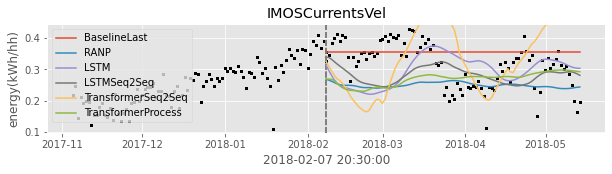

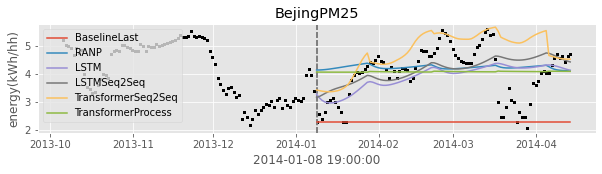

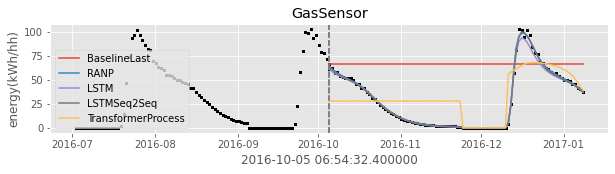

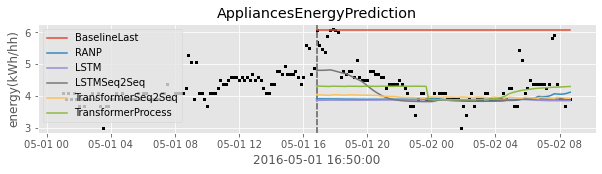

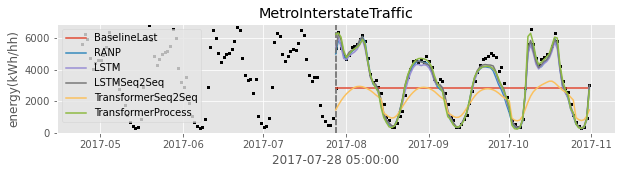

In [245]:
# Plot mean of predictions
for dataset in results.keys():
    for model in results[dataset].keys():
        ds_preds = results[dataset][model]
        plot_prediction(ds_preds, data_i, label=f"{model}")
    plt.title(dataset)
    plt.legend()
    plt.show()

/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


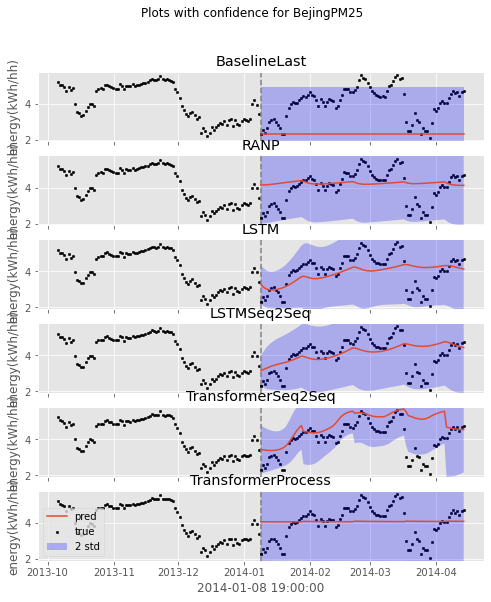

In [262]:
dataset='BejingPM25'
n = len(results[dataset].keys())

plt.figure(figsize=(8, 1.5*n))
plt.suptitle(f'Plots with confidence for {dataset} ')
for i, model in enumerate(results[dataset].keys()):
    plt.subplot(n, 1, i+1)
    ds_preds = results[dataset][model]
    if i==n-1:
        # The last one has the legend
        plot_prediction(ds_preds, data_i, title=f"{model}", std=True, legend=True)
    else:
        plot_prediction(ds_preds, data_i, title=f"{model}", std=True, )
        
        # share the x axis
        locs, _ = plt.xticks()
        plt.xticks(locs, labels=[])
        plt.xlabel(None)
plt.subplots_adjust()